# Bayesian Network Tutorial with Titanic Dataset

## 1. Introduction
 In this tutorial, you'll learn how to build a Bayesian Network using Python and the Titanic dataset.
 We'll cover the theory briefly, followed by hands-on coding using the pgmpy library.

 ## 2. What is a Bayesian Network?
 A Bayesian Network is a probabilistic graphical model that represents a set of variables and their conditional dependencies using a directed acyclic graph (DAG).
 - **Nodes**: Represent variables.
 - **Edges**: Represent conditional dependencies.
 - **CPDs**: Conditional Probability Distributions quantify relationships.

 ### Why use Bayesian Networks?
 - Handle missing data
 - Perform probabilistic inference
 - Encode expert knowledge in a graph structure


In [1]:

# ## 3. Install Required Packages
# !pip install pandas scikit-learn pgmpy pyvis

# ## 4. Load and Preprocess the Titanic Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from pgmpy.models import DiscreteBayesianNetwork 

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from math import ceil
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [14]:
df = pd.read_csv('concrete.csv')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [15]:
df.columns

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age', 'strength'],
      dtype='object')

In [4]:

# Select relevant features
df = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Embarked"]]

# Drop missing values for simplicity
df.dropna(inplace=True)


# Discretize Age into bins
df["Age"] = pd.cut(df["Age"], bins=3, labels=['child', 'adult', 'old'])

# Show preprocessed data
df.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,child,1,0,S
1,1,1,female,adult,1,0,C
2,1,3,female,child,0,0,S
3,1,1,female,adult,1,0,S
4,0,3,male,adult,0,0,S


In [5]:

# ## 5. Define the Bayesian Network Structure


# Manually define the structure
model = DiscreteBayesianNetwork ([
    ("Pclass", "Survived"),
    ("Sex", "Pclass"),
    ("Age", "Pclass"),
    ("SibSp", "Survived"),
    ("Parch", "Survived"),
    ("Embarked", "Survived")
])


In [6]:

# ## 6. Fit the Model
from pgmpy.estimators import MaximumLikelihoodEstimator

# Fit model using Maximum Likelihood Estimation
model.fit(df, estimator=MaximumLikelihoodEstimator)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Survived': 'N', 'Pclass': 'N', 'Sex': 'C', 'Age': 'O', 'SibSp': 'N', 'Parch': 'N', 'Embarked': 'C'}


In [7]:

# ## 7. Make Inference
from pgmpy.inference import VariableElimination

# Create inference object
inference = VariableElimination(model)


In [8]:

# Query: Probability of survival given Sex = female (0), Pclass = 1
query_result = inference.query(
    variables=["Survived"],
    evidence={"Sex": 'female', "Pclass": 1}
)

print(query_result)


+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.3820 |
+-------------+-----------------+
| Survived(1) |          0.6180 |
+-------------+-----------------+


In [9]:
print("Nodes:", list(model.nodes()))
print("Edges:", list(model.edges()))

Nodes: ['Pclass', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']
Edges: [('Pclass', 'Survived'), ('Sex', 'Pclass'), ('Age', 'Pclass'), ('SibSp', 'Survived'), ('Parch', 'Survived'), ('Embarked', 'Survived')]


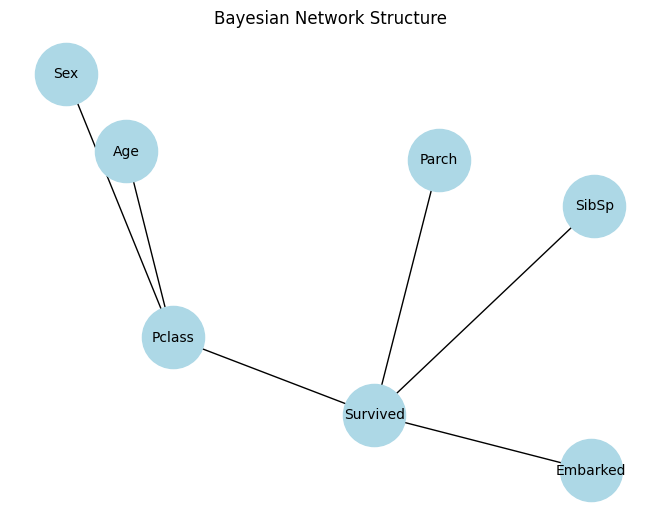

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

# Створюємо окремий граф із тієї ж структури
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

# Отримуємо layout
pos = nx.spring_layout(G)

# Малюємо граф
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=2000,
    node_color='lightblue',
    font_size=10,
    arrows=False
)
plt.title("Bayesian Network Structure")
plt.show()


In [11]:
# ## 8. Interactive Visualization with CPD Tooltips
from pyvis.network import Network
import html

net = Network(notebook=True, directed=True, height='800px', width='100%', bgcolor='#ffffff', font_color='black')

# Add nodes with nicely formatted CPD in HTML tooltip
for node in model.nodes():
    try:
        cpd = model.get_cpds(node)
        tooltip = f"<pre>{html.escape(str(cpd))}</pre>"
    except:
        tooltip = node
    net.add_node(node, label=node, title=tooltip, shape='dot', size=25)

# Add edges
for edge in model.edges():
    net.add_edge(*edge)

# Improve physics and layout
net.toggle_physics(True)
net.barnes_hut()

net.show("bayesian_network.html")

bayesian_network.html


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Survived': 'N', 'Pclass': 'N', 'Sex': 'C', 'Age': 'O', 'SibSp': 'N', 'Parch': 'N', 'Embarked': 'C'}


interactive(children=(Dropdown(description='Sex:', options=(('Female', 'female'), ('Male', 'male')), value='fe…

NameError: name 'cpds' is not defined

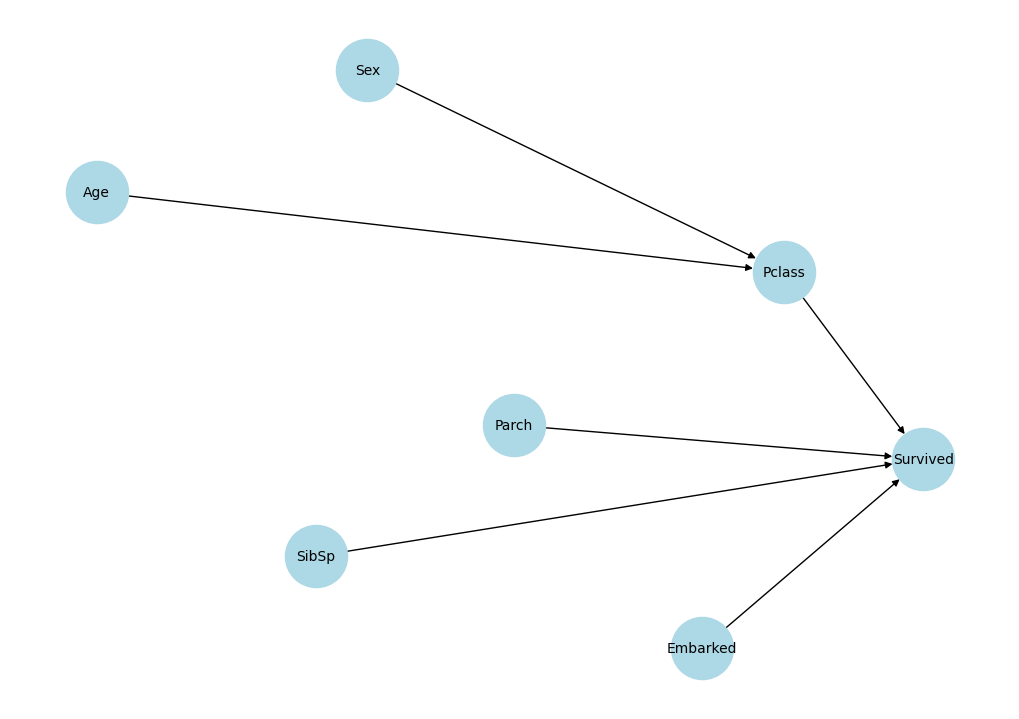

In [13]:
# ## 9. Evidence-Based Inference Input (Interactive with ipywidgets)
from ipywidgets import interact_manual, widgets

# Create dropdowns dynamically for all variables
from ipywidgets import Dropdown
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Визначимо root_variables — ті вузли, в яких немає батьків:
root_variables = [
    node
    for node in model.nodes()
    if len(model.get_parents(node)) == 0
]

dropdowns = {}
if "Sex" in root_variables:
    dropdowns["sex"] = widgets.Dropdown(options=[("Female", "female"), ("Male", "male")], description='Sex:')
if "Age" in root_variables:
    dropdowns["age"] = widgets.Dropdown(options=[("Young", 'child'), ("Adult", 'adult'), ("Old", 'old')], description='Age:')

@interact_manual(**dropdowns)
def compute_survival(**kwargs):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go
    from math import ceil

    evidence = {key.capitalize(): val for key, val in kwargs.items()}
    try:
        result = inference.query(variables=["Survived"], evidence=evidence)
    except:
        result = "Inference failed due to incompatible evidence."
    print("Inference Result:")
    print(result)

    # Visualize updated marginals for all CPDs under evidence
    cpds = model.get_cpds()
    fig = make_subplots(
        rows=ceil(len(cpds)/2), cols=2,
        subplot_titles=[cpd.variable for cpd in cpds],
        horizontal_spacing=0.15, vertical_spacing=0.2
    )

    row, col = 1, 1
    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            states = cpd.state_names[variable]
            probs = marginal.values
        except:
            states = cpd.state_names[variable]
            probs = [0 for _ in states]

        decoded_states = [f"{variable} = {s}" for s in states]
        fig.add_trace(
            go.Bar(x=decoded_states, y=probs, name=variable),
            row=row, col=col
        )

        col += 1
        if col > 2:
            row += 1
            col = 1

    fig.update_layout(height=400*ceil(len(cpds)/2), width=900, title_text="Posterior Distributions given Evidence")
    fig.show()

    # Tabular output of posterior probabilities
    import pandas as pd
    print("Posterior Probabilities (Tabular):")
    for cpd in cpds:
        variable = cpd.variable
        try:
            marginal = inference.query(variables=[variable], evidence=evidence)
            decoded_states = [f"{variable} = {s}" for s in cpd.state_names[variable]]
            df = pd.DataFrame({variable: decoded_states, "P(·|evidence)": marginal.values})
            display(df)
        except:
            continue

    # Re-display network structure with posterior probabilities above nodes
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())
pos = nx.spring_layout(G)

plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrows=True)

# Annotate nodes with posterior probabilities (exclude root variables)
for cpd in cpds:
    variable = cpd.variable
    # Display all nodes, including root variables
    try:
        marginal = inference.query(variables=[variable], evidence=evidence)
        states = cpd.state_names[variable]
        probs = marginal.values
        label = "".join([f"{variable} = {s}: {p:.2f}" for s, p in zip(states, probs)])
        x, y = pos[variable]
        plt.text(x, y + 0.08, label, fontsize=8, ha='center', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    except:
        continue

plt.title("Bayesian Network with Posterior Probabilities")
plt.axis('off')
plt.show()